In [1]:
import re
import glob
import pywt

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb


from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/Users/user/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Concatenate all the files

In [2]:
# get path to all files
path = 'data/spectra/simulated_data_10K/'

files = sorted(glob.glob(path + 'model_parameters_data*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))

output_path = 'data/params/'
# write_data = open(output_path + 'model_parameters_data_all_10K.txt', 'w')

# # read in all files
# for file in files:
#     with open(file, 'r') as f:
#         # skip the first 10 lines in each file
#         for i in range(10):
#             f.readline()
#         # read in the data from each file
#         data = f.readlines()
#         # write the data to the output file in the same order as the files
#         for i in range(len(data)):
#             write_data.write(data[i])

# write_data.close()  

In [3]:
# # get the params data
# df_param = pd.DataFrame()
# for file in files:
#     # get the parameters used
#     df_param = df_param.append(pd.read_csv(file, skiprows=1, nrows=6, header=None, sep=' ', names=['A', 'B', 'C', 'D']))
#     # save the dataframe to a csv file
# df_param.to_csv(output_path + 'model_parameters_data_10K.csv', index=False)

#### Load the files 

In [4]:
df_data = pd.read_csv(output_path + 'model_parameters_data_all_10K.txt', sep=' ', header=None) # all data dataframe
df_data.head()

0    1
0  238.60000  0.0
1  238.60001  0.0
2  238.60002  0.0
3  238.60003  0.0
4  238.60004  0.0

In [5]:
df_data.shape

(580000000, 2)

In [6]:
df_param = pd.read_csv(output_path + 'model_parameters_data_10K.csv')
df_param.head()

A  B             C     D
0  tcmb  =  2.730000e+00     K
1  ntot  =  5.888377e+17  cm-2
2   tex  =  3.929676e+02     K
3  fwhm  =  1.104218e+00  km/s
4  vlsr  =  7.965879e+01  km/s

In [7]:
# drop the second and fourth column
df_param.drop(['B', 'D'], axis=1, inplace=True)

In [8]:
# tranform the data to the right dataframe
df_param = df_param.assign(g = df_param.groupby('A').cumcount()).pivot(index='g', columns='A', values='C')

In [9]:
df_param.head(10)

A      fwhm          ntot      size  tcmb         tex        vlsr
g                                                                
0  1.104218  5.888377e+17  0.365643  2.73  392.967603   79.658791
1  1.311138  2.510638e+17  1.193705  2.73  209.445129   24.579956
2  6.637987  7.819653e+16  1.493372  2.73  120.944377   89.281443
3  4.578995  6.434423e+16  1.694034  2.73  139.142766   56.959016
4  3.581212  1.328970e+16  0.798906  2.73  301.743569   35.268285
5  9.396579  2.051602e+17  1.394765  2.73  173.831739  -13.857208
6  5.535242  2.884339e+16  1.799545  2.73   76.906965   45.644163
7  7.010329  2.162035e+17  2.369049  2.73  365.886855  127.833799
8  9.328934  9.712072e+16  0.482378  2.73  274.095481   71.392899
9  1.617589  1.900196e+16  1.784981  2.73  174.000834 -117.757348

In [10]:
df_param.columns

Index(['fwhm', 'ntot', 'size', 'tcmb', 'tex', 'vlsr'], dtype='object', name='A')

In [11]:
columns = ['Frequency', 'Intensity']
df_data.columns = columns
df_data.shape

(580000000, 2)

In [12]:
df_data.head()

Frequency  Intensity
0  238.60000        0.0
1  238.60001        0.0
2  238.60002        0.0
3  238.60003        0.0
4  238.60004        0.0

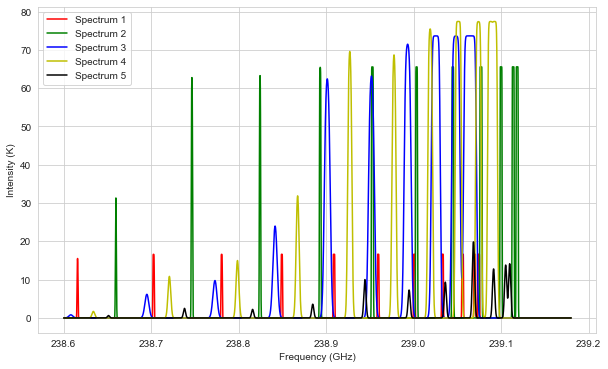

In [13]:
freq_sig = np.array(np.array_split(df_data['Frequency'], len(files)))
signal = np.array(np.array_split(df_data['Intensity'], len(files)))

# plot the signal in one plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(freq_sig[0],  signal[0], color='r', label='Spectrum 1')
plt.plot(freq_sig[1], signal[1], color='g', label='Spectrum 2')
plt.plot(freq_sig[2], signal[2], color='b', label='Spectrum 3')
plt.plot(freq_sig[3], signal[3], color='y', label='Spectrum 4')
plt.plot(freq_sig[4], signal[4], color='k', label='Spectrum 5')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (K)")
plt.legend()
plt.show()

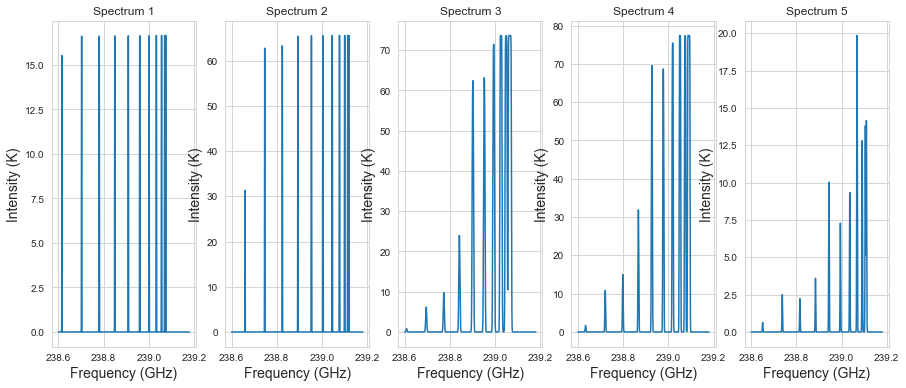

In [14]:
# plot the data in separate plots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
sns.set_style("whitegrid")
for i, ax in enumerate(axes.ravel(), start=1):
    ax.plot(freq_sig[i-1], signal[i-1], label='Spectrum {}'.format(i))
    ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
    ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
    ax.set_title("Spectrum {}".format(i))
    
# plt.savefig('../spectra/simulated_data/spectrum_plots.png')

In [15]:
# print(pywt.wavelist())

### Feature Extraction - Wavelet Decomposition

In [16]:
#create a  feature vector array for each spectrum 
feature_vector = np.zeros((len(signal), int(df_data.shape[0]/len(files))))
detail_coeffs = np.zeros((len(signal), 907))
approx_coeffs = np.zeros((len(signal), 907))
level = 6
wname = 'coif6'
def decompose_signal_dwt(_signal, wavelet=wname, mode='per', level=level):
    """
    Performs wavelet denoising on the given signal.
    """
    # loop throuh all the spectra 
    for spectra_index in range(len(_signal)):
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        coeffs = pywt.wavedec(_signal[spectra_index], wavelet=wavelet, mode=mode, level=level)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        detail_coeffs[spectra_index, :] = coeff_arr[coeff_slices[1]['d']] # 4th level detail coeffs 
        # get the approximation coeffs
        approx_coeffs[spectra_index, :] = coeffs[0] # 4th level approximation coeffs
        
        reconstructed_signal = pywt.waverec(coeffs, wavelet=wavelet, mode=mode)
        feature_vector[spectra_index, :] = coeff_arr[:int(df_data.shape[0]/len(files))]
        # add the coeff_arr to the dataframe for each spectra
        # df_data['fv_dwt_{}'.format(wavelet)] = pd.Series(feature_vector.reshape(1, -1)[0], index=df_data.index) #TODO: find a way to optimize (or comment it out)
        
    return coeff_arr, coeff_slices

In [17]:
feature_vector.shape

(10000, 58000)

In [18]:
coeff_arr, coeff_slices = decompose_signal_dwt(signal)
df_data

Frequency  Intensity
0          238.60000        0.0
1          238.60001        0.0
2          238.60002        0.0
3          238.60003        0.0
4          238.60004        0.0
...              ...        ...
579999995  239.17995        0.0
579999996  239.17996        0.0
579999997  239.17997        0.0
579999998  239.17998        0.0
579999999  239.17999        0.0

[580000000 rows x 2 columns]

In [19]:
detail_coeffs.shape
detail_coeffs

array([[ 0.00000000e+00,  0.00000000e+00, -4.05207595e-55, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.37555489e-03,  3.05787865e-04, -1.77440358e-04, ...,
         1.85245870e-04, -1.96502555e-04,  2.24139576e-03],
       ...,
       [ 6.73892699e+01, -1.38557138e+01,  9.99737602e+00, ...,
        -1.26807965e+01,  1.93295337e+01, -1.53218596e+02],
       [-2.78550665e-18,  5.28012561e-19, -7.49363132e-20, ...,
         1.37992392e-16, -4.38303914e-17,  1.12741106e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Wavelet Decomposition Plots

In [20]:
def decomposed_dwt_detail_coeffs_plots(_signal, wavelet=wname, level=level):
    """
    Plots of the detail coeffs of the signal.
    """
    # plot the reconstructed signal and the original signal in one plot
    for spectra_index in range(len(_signal)):                     
        # compute the maximum useful level of decomposition for each wavelet                        
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        fig, axes = plt.subplots(nrows=1, ncols=level, dpi=400, sharey='none', sharex='all', figsize=(18, 5))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[i]['d']], label='Level {}'.format(i))
            ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
            ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
            ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 
            
        plt.show()

In [21]:
# decomposed_dwt_detail_coeffs_plots(signal) 

In [22]:
# TODO: find a way to plot the detail coefficients of the signal
def decomposed_dwt_approx_coeffs_plots(_signal, wavelet=wname, level=level):
    
    for spectra_index in range(len(_signal)):
        fig, axes = plt.subplots(nrows=1, ncols=level, figsize=(10, 6))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[1]['d']])
            ax.set_title("Spectrum {} approximation coeffiecients at level {} for {} ".format(spectra_index+1, i,  wavelet))
            
        plt.show()

In [23]:
# decomposed_dwt_approx_coeffs_plots(signal)

### Get Features and Labels

In [24]:
# fv = np.zeros((len(signal), int(df.shape[0]/len(files))))
# for spectra_index in range(len(signal)):
#     # get the level 3 detail coefficients
#     detail_coeffs = coeff_arr[coeff_slices[3]['d']]

# fv  = detail_coeffs
# labels =dff

In [25]:
# len(signal)

approx_coeffs.shape

(10000, 907)

 #### Have a glimpse look at any of the signal and its generated detail and approximation coefficients 

In [26]:

# for spectra_index in range(len(signal)):                     
#         # compute the maximum useful level of decomposition for each wavelet                        
#         # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
#         fig, axes = plt.subplots(nrows=1, ncols=10, sharey='none', sharex='all', figsize=(20, 7))
#         sns.set_style("whitegrid")
#         for i, ax in enumerate(axes.ravel(), start=1):
#             ax.plot(signal[spectra_index], label='Spectrum {}'.format(spectra_index))
#             # ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
#             # ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
#             # ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 

#     # ax[0,1].plot(signal[spectra_index], label='original')
#     # ax[1,1].plot(approx_coeffs[spectra_index], label='spectrum {} approx coeff'.format(spectra_index+1))
#     # ax[2,1].plot(detail_coeffs[spectra_index], label='spectrum {} detail coeff'.format(spectra_index+1))
# plt.legend()
# plt.show()

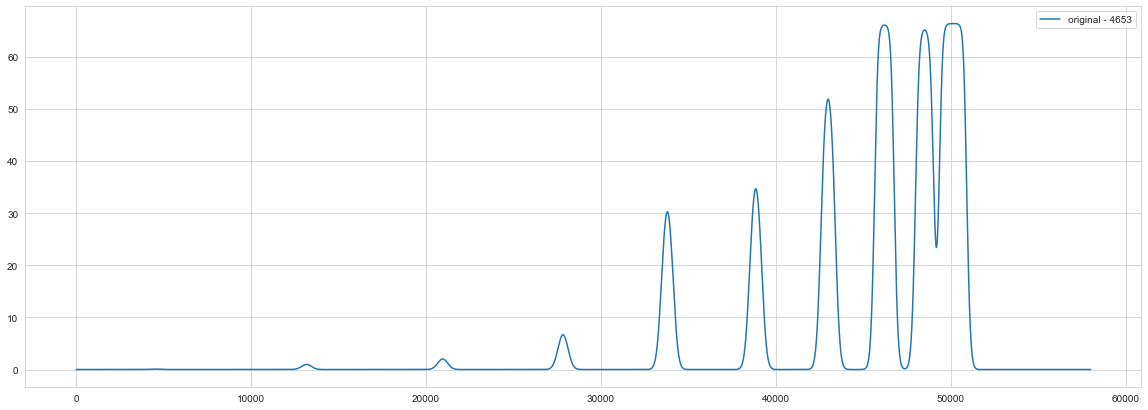

In [27]:
plt.figure(figsize=(20,7))
plt.plot(signal[4653], label='original - 4653')
plt.legend()
plt.savefig("data/10K_gen_files/original.png")
plt.show()

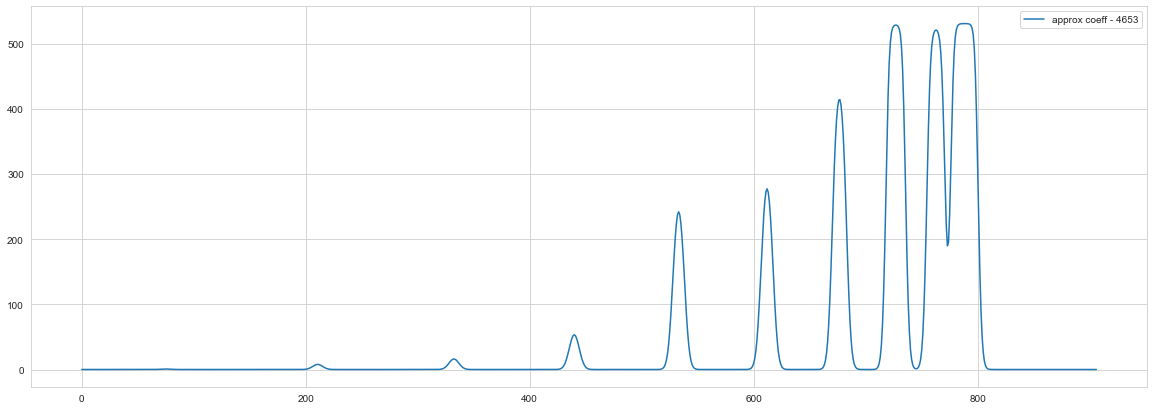

In [28]:
plt.figure(figsize=(20,7))
plt.plot(approx_coeffs[4653], label='approx coeff - 4653')
plt.legend()
plt.savefig("data/10K_gen_files/approx.png")
plt.show()

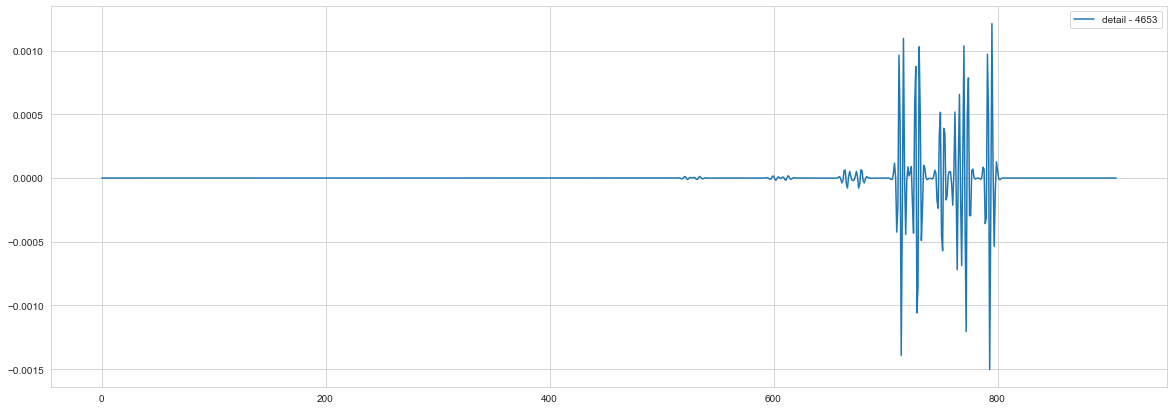

In [29]:
plt.figure(figsize=(20,7))
plt.plot(detail_coeffs[4653], label='detail - 4653')
plt.legend()
plt.savefig("data/10K_gen_files/detail.png")
plt.show()

In [30]:
features = detail_coeffs
labels_ = df_param

print('feature_shape: ', features.shape, 'labels_shape: ', labels_.shape)

feature_shape:  (10000, 907) labels_shape:  (10000, 6)


In [31]:
# labels_.drop(columns=['tcmb'], inplace=True)

#### save the true parameters to a file

In [32]:
labels_

A         fwhm          ntot      size  tcmb         tex        vlsr
g                                                                   
0     1.104218  5.888377e+17  0.365643  2.73  392.967603   79.658791
1     1.311138  2.510638e+17  1.193705  2.73  209.445129   24.579956
2     6.637987  7.819653e+16  1.493372  2.73  120.944377   89.281443
3     4.578995  6.434423e+16  1.694034  2.73  139.142766   56.959016
4     3.581212  1.328970e+16  0.798906  2.73  301.743569   35.268285
...        ...           ...       ...   ...         ...         ...
9995  3.510950  8.834151e+16  2.287943  2.73   20.132487   57.424608
9996  2.907827  7.634836e+16  1.929440  2.73  362.118917  -75.890725
9997  8.238700  7.897673e+17  2.244999  2.73  330.387721 -104.401538
9998  8.326096  2.395510e+16  1.970493  2.73   72.088183  -16.738557
9999  1.189584  7.772034e+17  1.553216  2.73  340.288271   52.182076

[10000 rows x 6 columns]

In [33]:
labels_.drop(columns=['tcmb'], inplace=True)

In [34]:
# get the last 3000 data of the parameters from labels 
df_param = df_param.iloc[-3000:, :]
# save the vals to a csv file
df_param.to_csv("data/10K_gen_files/true_param_vals.csv")
df_param.head()

A         fwhm          ntot      size         tex        vlsr
g                                                             
7000  8.277957  3.547592e+17  1.224458  288.842953   99.263494
7001  5.022305  3.637225e+17  1.638663  167.839263   60.218975
7002  2.712427  3.635302e+17  1.750680  201.175288 -106.634146
7003  8.666178  5.381971e+16  0.664417   11.992266 -105.522675
7004  4.453063  1.146947e+17  0.455909  246.051514  -80.721674

In [35]:
df = pd.DataFrame(approx_coeffs)

In [36]:
df

0             1             2             3             4    \
0     0.000000e+00  0.000000e+00 -4.236853e-59 -1.700942e-46 -5.867105e-42   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    -1.724022e-05  5.141306e-05 -1.355962e-04  3.613813e-04 -9.806227e-04   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  2.483805e+01  1.316246e+02  2.469955e+02  3.881978e+02  5.602747e+02   
9997  6.718953e+02  6.672227e+02  6.800508e+02  6.479492e+02  7.263756e+02   
9998  1.148500e-15 -3.537846e-16  1.280122e-16 -2.419984e-17  3.133399e-18   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               5             6             7             8             9    \
0    -1.131871e-35 -1.579997e-31 -1.709550e-30 -1.828596e-26  1.478300e-21   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     8.090383e-03  3.189991e-02  7.606479e-02  1.717340e-01  3.561268e-01   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  2.249120e+02 -3.691602e+01  1.175815e+01 -3.336094e+00  6.966394e-01   
9997  2.713875e+02 -4.388532e+01  1.393161e+01 -3.957500e+00  8.294872e-01   
9998 -5.876214e-20 -3.203194e-21 -9.453978e-23  5.576446e-24 -4.530599e-26   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

      ...           897           898           899           900  \
0     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     ...  1.052277e-15  2.094833e-13 -3.639334e-12  3.274123e-11   
3     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...   ...           ...           ...           ...           ...   
9995  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  ... -2.780397e-07 -1.031602e-07 -1.416790e-05  2.598835e-04   
9997  ...  5.672248e+01  1.092920e+02  1.931781e+02  3.082920e+02   
9998  ...  1.154071e-07  2.313461e-08  4.406776e-09  7.979096e-10   
9999  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               901           902           903           904           905  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    -3.293064e-10  3.818465e-09 -3.575151e-08  2.488638e-07 -1.295111e-06   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996 -2.575486e-03  1.663722e-02 -7.461142e-02  2.825404e-01 -3.921728e-01   
9997  4.379222e+02  5.513437e+02  6.243567e+02  6.574841e+02  6.680301e+02   
9998  1.374098e-10  2.252140e-11  3.522056e-12  5.235008e-13  7.464218e-14   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               906  
0     0.000000e+00  
1     0.000000e+00  
2     5.193909e-06  
3     0.000000e+00  
4     0.000000e+00  
...            ...  
9995  0.000000e+00  
9996  5.658809e+00  
9997  6.699943e+02  
9998 -8.461201e-16  
9999  0.000000e+00  

[10000 rows x 907 columns]

In [37]:
df = pd.concat([df, labels_], axis=1)
df.head()

0         1             2             3             4             5  \
0  0.000000  0.000000 -4.236853e-59 -1.700942e-46 -5.867105e-42 -1.131871e-35   
1  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2 -0.000017  0.000051 -1.355962e-04  3.613813e-04 -9.806227e-04  8.090383e-03   
3  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              6             7             8             9  ...           902  \
0 -1.579997e-31 -1.709550e-30 -1.828596e-26  1.478300e-21  ...  0.000000e+00   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   
2  3.189991e-02  7.606479e-02  1.717340e-01  3.561268e-01  ...  3.818465e-09   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   

            903           904       905       906      fwhm          ntot  \
0  0.000000e+00  0.000000e+00  0.000000  0.000000  1.104218  5.888377e+17   
1  0.000000e+00  0.000000e+00  0.000000  0.000000  1.311138  2.510638e+17   
2 -3.575151e-08  2.488638e-07 -0.000001  0.000005  6.637987  7.819653e+16   
3  0.000000e+00  0.000000e+00  0.000000  0.000000  4.578995  6.434423e+16   
4  0.000000e+00  0.000000e+00  0.000000  0.000000  3.581212  1.328970e+16   

       size         tex       vlsr  
0  0.365643  392.967603  79.658791  
1  1.193705  209.445129  24.579956  
2  1.493372  120.944377  89.281443  
3  1.694034  139.142766  56.959016  
4  0.798906  301.743569  35.268285  

[5 rows x 912 columns]

In [38]:
# convert the ntot column to log values 
df['ntot'] = np.log10(df['ntot'])

In [39]:
df

0             1             2             3             4  \
0     0.000000e+00  0.000000e+00 -4.236853e-59 -1.700942e-46 -5.867105e-42   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    -1.724022e-05  5.141306e-05 -1.355962e-04  3.613813e-04 -9.806227e-04   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  2.483805e+01  1.316246e+02  2.469955e+02  3.881978e+02  5.602747e+02   
9997  6.718953e+02  6.672227e+02  6.800508e+02  6.479492e+02  7.263756e+02   
9998  1.148500e-15 -3.537846e-16  1.280122e-16 -2.419984e-17  3.133399e-18   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                 5             6             7             8             9  \
0    -1.131871e-35 -1.579997e-31 -1.709550e-30 -1.828596e-26  1.478300e-21   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     8.090383e-03  3.189991e-02  7.606479e-02  1.717340e-01  3.561268e-01   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  2.249120e+02 -3.691602e+01  1.175815e+01 -3.336094e+00  6.966394e-01   
9997  2.713875e+02 -4.388532e+01  1.393161e+01 -3.957500e+00  8.294872e-01   
9998 -5.876214e-20 -3.203194e-21 -9.453978e-23  5.576446e-24 -4.530599e-26   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

      ...           902           903           904           905  \
0     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     ...  3.818465e-09 -3.575151e-08  2.488638e-07 -1.295111e-06   
3     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...   ...           ...           ...           ...           ...   
9995  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  ...  1.663722e-02 -7.461142e-02  2.825404e-01 -3.921728e-01   
9997  ...  5.513437e+02  6.243567e+02  6.574841e+02  6.680301e+02   
9998  ...  2.252140e-11  3.522056e-12  5.235008e-13  7.464218e-14   
9999  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               906      fwhm       ntot      size         tex        vlsr  
0     0.000000e+00  1.104218  17.769996  0.365643  392.967603   79.658791  
1     0.000000e+00  1.311138  17.399784  1.193705  209.445129   24.579956  
2     5.193909e-06  6.637987  16.893187  1.493372  120.944377   89.281443  
3     0.000000e+00  4.578995  16.808510  1.694034  139.142766   56.959016  
4     0.000000e+00  3.581212  16.123515  0.798906  301.743569   35.268285  
...            ...       ...        ...       ...         ...         ...  
9995  0.000000e+00  3.510950  16.946165  2.287943   20.132487   57.424608  
9996  5.658809e+00  2.907827  16.882800  1.929440  362.118917  -75.890725  
9997  6.699943e+02  8.238700  17.897499  2.244999  330.387721 -104.401538  
9998 -8.461201e-16  8.326096  16.379398  1.970493   72.088183  -16.738557  
9999  0.000000e+00  1.189584  17.890535  1.553216  340.288271   52.182076  

[10000 rows x 912 columns]

In [40]:
X = df.iloc[:, :907]
y = df.iloc[:, -5:]

In [41]:
X

0             1             2             3             4    \
0     0.000000e+00  0.000000e+00 -4.236853e-59 -1.700942e-46 -5.867105e-42   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    -1.724022e-05  5.141306e-05 -1.355962e-04  3.613813e-04 -9.806227e-04   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  2.483805e+01  1.316246e+02  2.469955e+02  3.881978e+02  5.602747e+02   
9997  6.718953e+02  6.672227e+02  6.800508e+02  6.479492e+02  7.263756e+02   
9998  1.148500e-15 -3.537846e-16  1.280122e-16 -2.419984e-17  3.133399e-18   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               5             6             7             8             9    \
0    -1.131871e-35 -1.579997e-31 -1.709550e-30 -1.828596e-26  1.478300e-21   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     8.090383e-03  3.189991e-02  7.606479e-02  1.717340e-01  3.561268e-01   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  2.249120e+02 -3.691602e+01  1.175815e+01 -3.336094e+00  6.966394e-01   
9997  2.713875e+02 -4.388532e+01  1.393161e+01 -3.957500e+00  8.294872e-01   
9998 -5.876214e-20 -3.203194e-21 -9.453978e-23  5.576446e-24 -4.530599e-26   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

      ...           897           898           899           900  \
0     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     ...  1.052277e-15  2.094833e-13 -3.639334e-12  3.274123e-11   
3     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...   ...           ...           ...           ...           ...   
9995  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  ... -2.780397e-07 -1.031602e-07 -1.416790e-05  2.598835e-04   
9997  ...  5.672248e+01  1.092920e+02  1.931781e+02  3.082920e+02   
9998  ...  1.154071e-07  2.313461e-08  4.406776e-09  7.979096e-10   
9999  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               901           902           903           904           905  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    -3.293064e-10  3.818465e-09 -3.575151e-08  2.488638e-07 -1.295111e-06   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996 -2.575486e-03  1.663722e-02 -7.461142e-02  2.825404e-01 -3.921728e-01   
9997  4.379222e+02  5.513437e+02  6.243567e+02  6.574841e+02  6.680301e+02   
9998  1.374098e-10  2.252140e-11  3.522056e-12  5.235008e-13  7.464218e-14   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               906  
0     0.000000e+00  
1     0.000000e+00  
2     5.193909e-06  
3     0.000000e+00  
4     0.000000e+00  
...            ...  
9995  0.000000e+00  
9996  5.658809e+00  
9997  6.699943e+02  
9998 -8.461201e-16  
9999  0.000000e+00  

[10000 rows x 907 columns]

In [42]:
y

fwhm       ntot      size         tex        vlsr
0     1.104218  17.769996  0.365643  392.967603   79.658791
1     1.311138  17.399784  1.193705  209.445129   24.579956
2     6.637987  16.893187  1.493372  120.944377   89.281443
3     4.578995  16.808510  1.694034  139.142766   56.959016
4     3.581212  16.123515  0.798906  301.743569   35.268285
...        ...        ...       ...         ...         ...
9995  3.510950  16.946165  2.287943   20.132487   57.424608
9996  2.907827  16.882800  1.929440  362.118917  -75.890725
9997  8.238700  17.897499  2.244999  330.387721 -104.401538
9998  8.326096  16.379398  1.970493   72.088183  -16.738557
9999  1.189584  17.890535  1.553216  340.288271   52.182076

[10000 rows x 5 columns]

In [43]:
# from sklearn.preprocessing import LabelEncoder

# lbl_enc = LabelEncoder()

# labl = lbl_enc.fit_transform(labels_)

In [44]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
    )

print('X_train shape: ',  X_train.shape, '\n',
    'y_train shape: ', y_train.shape, '\n',
    'X_test shape: ', X_test.shape, '\n',
    'y_test shape: ', y_test.shape)

X_train shape:  (7000, 907) 
 y_train shape:  (7000, 5) 
 X_test shape:  (3000, 907) 
 y_test shape:  (3000, 5)


## 1. Multioutput Regressor - Random Forest

In [45]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler


regr_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
    n_estimators=800, 
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    max_depth=130,
    bootstrap=True
    )
)

regr_multirf.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=130,
                                                     n_estimators=800))

In [46]:
#  predict on the new test data
y_multirf_pred = regr_multirf.predict(X_test)

In [47]:
regr_multirf.score(X_test, y_test)

0.806138615141635

#### Metrics

In [48]:
class RegressionMetrics:
    def __init__(self):
        self.metrics = {
            "mae": self._mean_absolute_error,
            "mse": self._mean_squared_error,
            "rmse": self._root_mean_squared_error,
            "mape": self._mean_absolute_percentage_error,
            "r2": self._r2_score,
            "msle": self._mean_squared_log_error,
            # "rmsle": self._root_mean_squared_logarithmic_error,
        }

    def get_metric(self, metric,  y_true, y_pred):
        if metric not in self.metrics:
            raise Exception("Metric not found")
        
        if metric == "mae":
            return self._mean_absolute_error(y_true, y_pred)
        if metric == "mse":
            return self._mean_squared_error(y_true, y_pred)
        if metric == "rmse":
            return self._root_mean_squared_error(y_true, y_pred)
        if metric == "mape":
            return self._mean_absolute_percentage_error(y_true, y_pred)
        if metric == "r2":
            return self._r2_score(y_true, y_pred)
        if metric == "msle":
            return self._mean_squared_log_error(y_true, y_pred)
        # if metric == "rmsle":
        #     return self._root_mean_squared_logarithmic_error(y_true, y_pred)
        
    @staticmethod
    def _mean_absolute_error(y_true, y_pred):
        return metrics.mean_absolute_error(y_true, y_pred)

    @staticmethod
    def _mean_squared_error( y_true, y_pred):
        return metrics.mean_squared_error(y_true, y_pred)

    def _root_mean_squared_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    def _mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    @staticmethod
    def _r2_score(y_true, y_pred):
        return metrics.r2_score(y_true, y_pred)
    
    def _mean_squared_log_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    # def _root_mean_squared_logarithmic_error(self, y_true, y_pred):
    #     return np.sqrt(np.mean(np.square(np.log(y_pred + 1) - np.log(y_true + 1))))


In [49]:
metrics_multirf = RegressionMetrics()
_metrics = ['mae', 'mse', 'rmse', 'mape', 'r2', 'msle']
for metric in _metrics:
    print("Multirf  {}: ".format(metric), metrics_multirf.get_metric(metric, y_test, y_multirf_pred))

Multirf  mae:  8.981752808460858
Multirf  mse:  635.7746999602688
Multirf  rmse:  25.21457316633119
Multirf  mape:  fwhm     7.652113
ntot     1.573813
size    31.206862
tex     26.913286
vlsr    34.855987
dtype: float64
Multirf  r2:  0.806138615141635
Multirf  msle:  25.21457316633119


### save the predicted parameters to a csv file 

In [50]:
param_df_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm_rf_pred', 'ntot_rf_pred', 'size_rf_pred', 'tex_rf_pred', 'vlsr_rf_pred'], index=X_test.index)
param_df_rf.head()

fwhm_rf_pred  ntot_rf_pred  size_rf_pred  tex_rf_pred  vlsr_rf_pred
6252      5.803068     16.454745      0.979896   198.686929    -65.799794
4684      2.738055     17.369703      1.757514   187.077338   -122.814219
1731      4.284896     16.641667      1.974926    59.991608    -44.419422
4742      3.081001     17.167107      1.494495   237.017818    -79.014063
4521      2.717093     17.405456      1.945188   258.876483    -79.914817

In [51]:
# convert back the log to linear values 
param_df_rf['ntot_rf_pred'] = np.array(10**param_df_rf['ntot_rf_pred'])

In [52]:
param_df_rf.to_csv('data/10K_gen_files/predicted_parameters_rf.csv', index=True)
param_df_rf.shape

(3000, 5)

In [53]:
pred_para = pd.read_csv('data/10K_gen_files/predicted_parameters_rf.csv')
true_para = pd.read_csv('data/10K_gen_files/true_param_vals.csv')

# add the predicted value to the true value dataframe as new columns separated by an empty column 
true_para = pd.concat([true_para,  pd.DataFrame(np.zeros(len(true_para))), pred_para], axis=1)
true_para.to_csv('data/10K_gen_files/true_param_vals_with_predicted_rf.csv')
true_para.head()

g      fwhm          ntot      size         tex        vlsr    0  \
0  7000  8.277957  3.547592e+17  1.224458  288.842953   99.263494  0.0   
1  7001  5.022305  3.637225e+17  1.638663  167.839263   60.218975  0.0   
2  7002  2.712427  3.635302e+17  1.750680  201.175288 -106.634146  0.0   
3  7003  8.666178  5.381971e+16  0.664417   11.992266 -105.522675  0.0   
4  7004  4.453063  1.146947e+17  0.455909  246.051514  -80.721674  0.0   

   Unnamed: 0  fwhm_rf_pred  ntot_rf_pred  size_rf_pred  tex_rf_pred  \
0        6252      5.803068  2.849342e+16      0.979896   198.686929   
1        4684      2.738055  2.342626e+17      1.757514   187.077338   
2        1731      4.284896  4.381946e+16      1.974926    59.991608   
3        4742      3.081001  1.469288e+17      1.494495   237.017818   
4        4521      2.717093  2.543642e+17      1.945188   258.876483   

   vlsr_rf_pred  
0    -65.799794  
1   -122.814219  
2    -44.419422  
3    -79.014063  
4    -79.914817

### Predicted vs True values plots

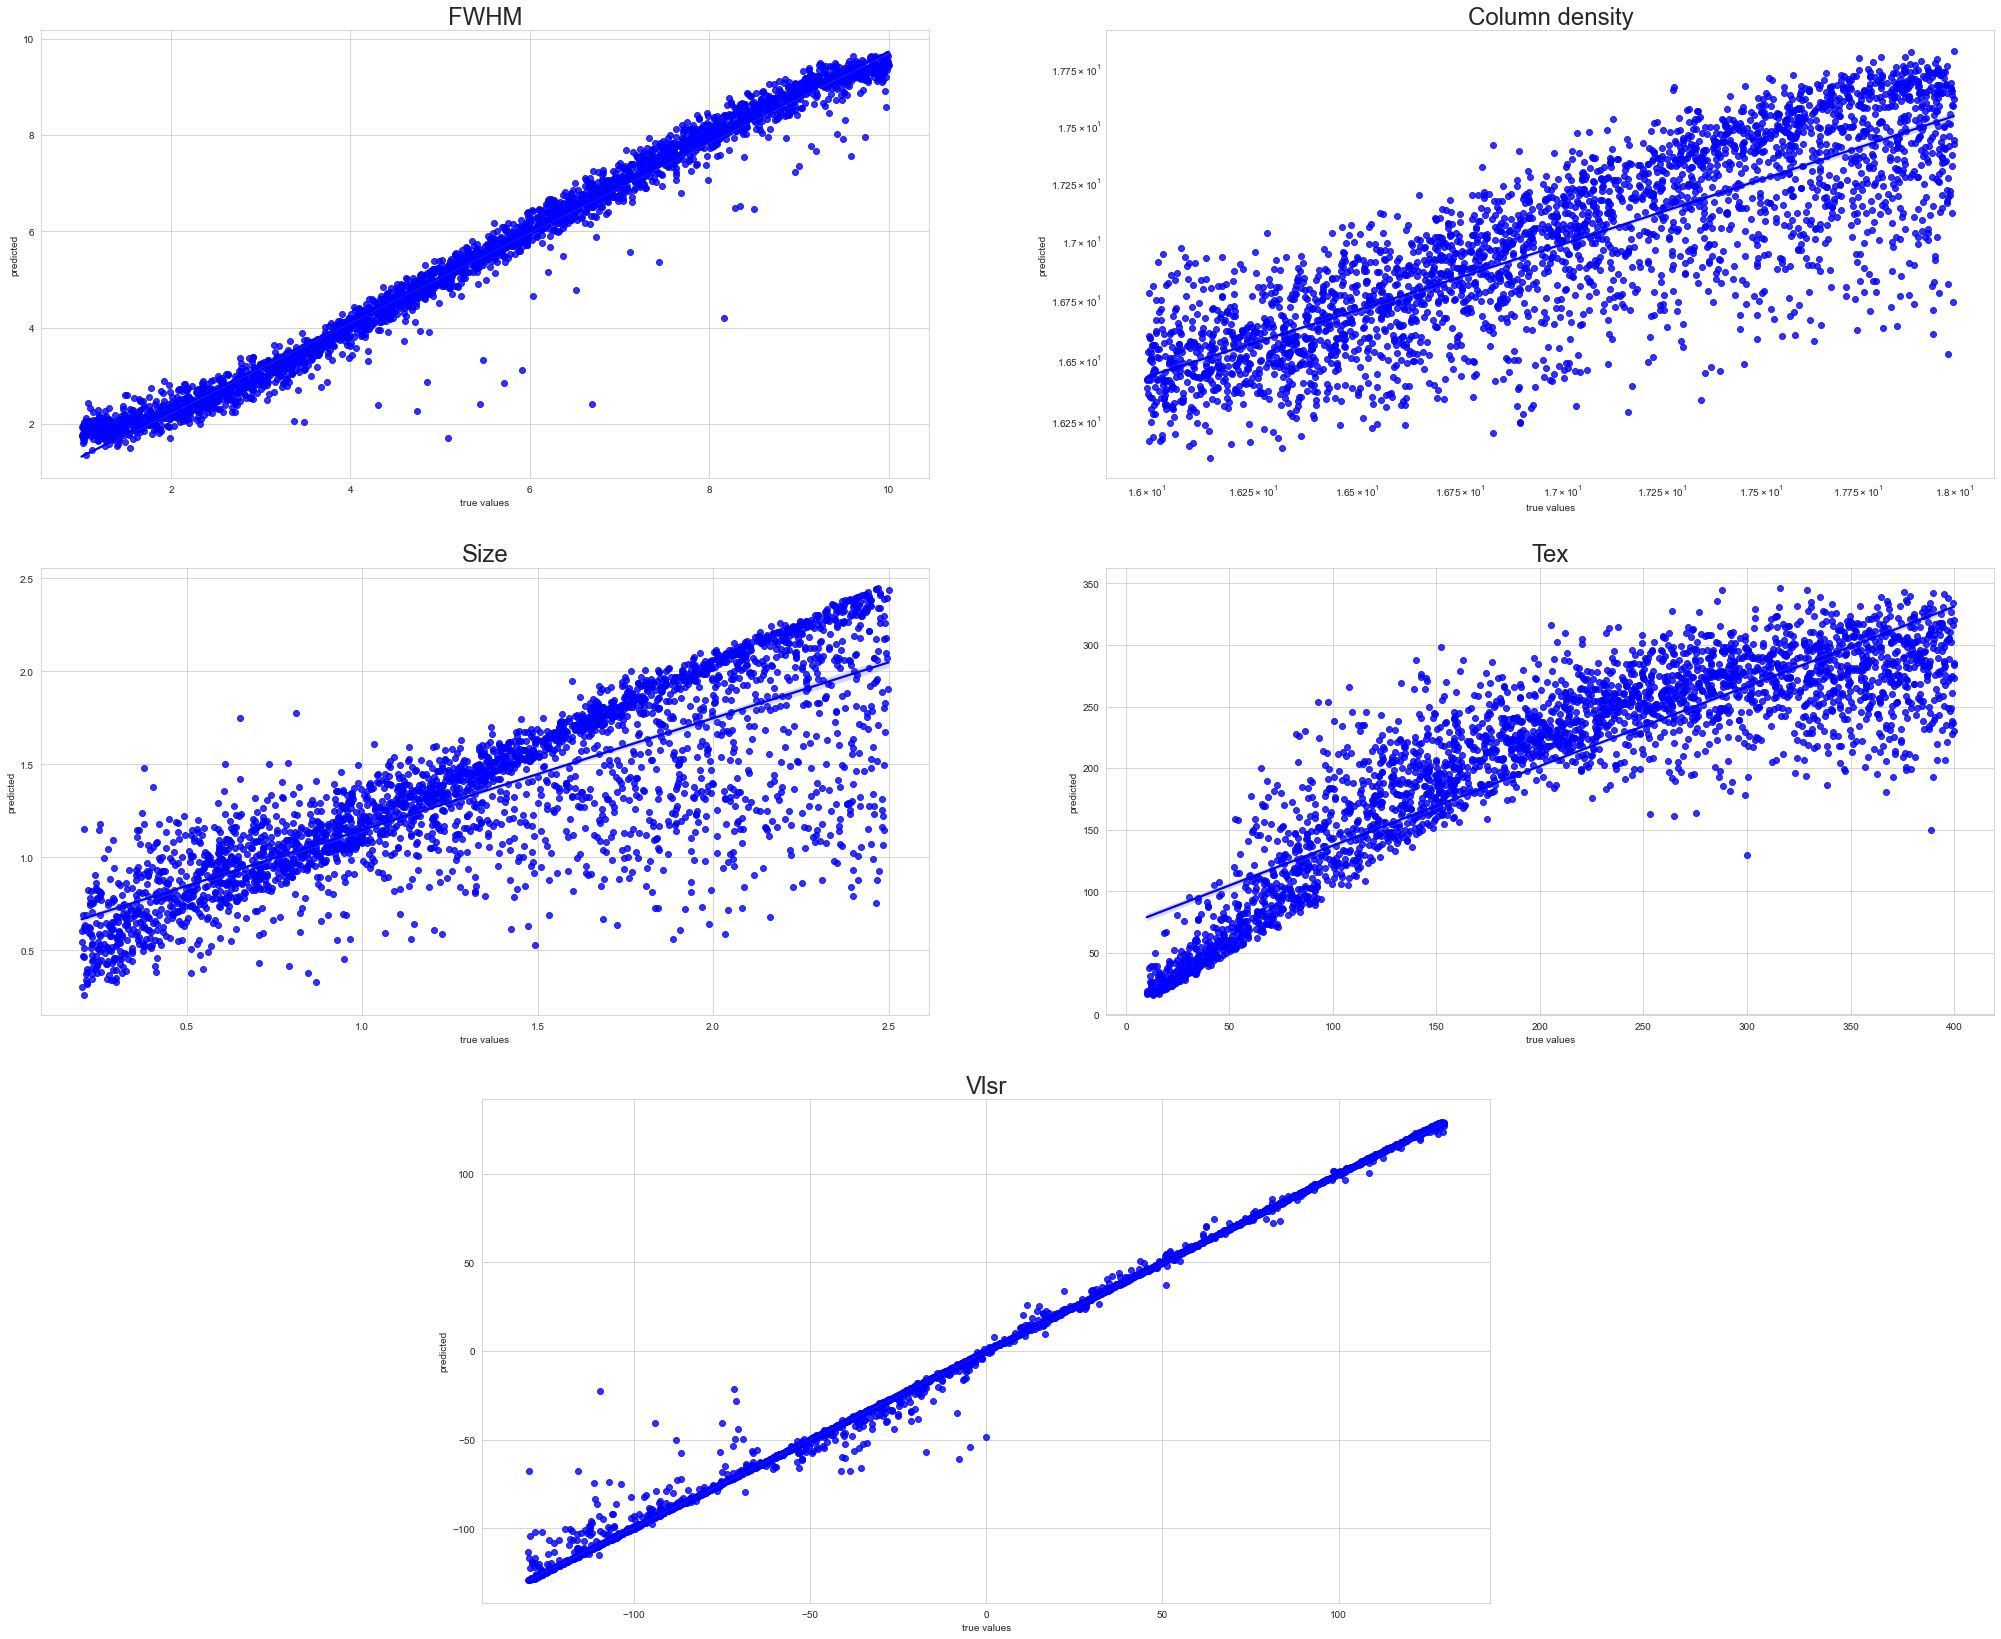

In [54]:
fig, axes = plt.subplots(3, 2, figsize=(35,28))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2)
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_pred[:,0], color='blue', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_pred[:,1], color='blue', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_pred[:,2], color='blue', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_pred[:,3], color='blue', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_pred[:,4], color='blue', ax=axes[2,0]) # vlsr


g1.set(title='FWHM', ylabel="predicted", xlabel="true values")
g2.set(title='Column density', ylabel="predicted", xlabel="true values", yscale="log", xscale="log")
g3.set(title='Size', ylabel="predicted", xlabel="true values")
g4.set(title='Tex', ylabel="predicted", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted", xlabel="true values")

plt.savefig("data/10K_gen_files/pred_true_10K_RF.png")

plt.show()

### 3D Plots -cColumnn density, Excitation temperature and Size

In [55]:
pred_param = pd.DataFrame(y_multirf_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param.head()

fwhm       ntot      size         tex        vlsr
0  5.803068  16.454745  0.979896  198.686929  -65.799794
1  2.738055  17.369703  1.757514  187.077338 -122.814219
2  4.284896  16.641667  1.974926   59.991608  -44.419422
3  3.081001  17.167107  1.494495  237.017818  -79.014063
4  2.717093  17.405456  1.945188  258.876483  -79.914817

### Residuals - Random Forest

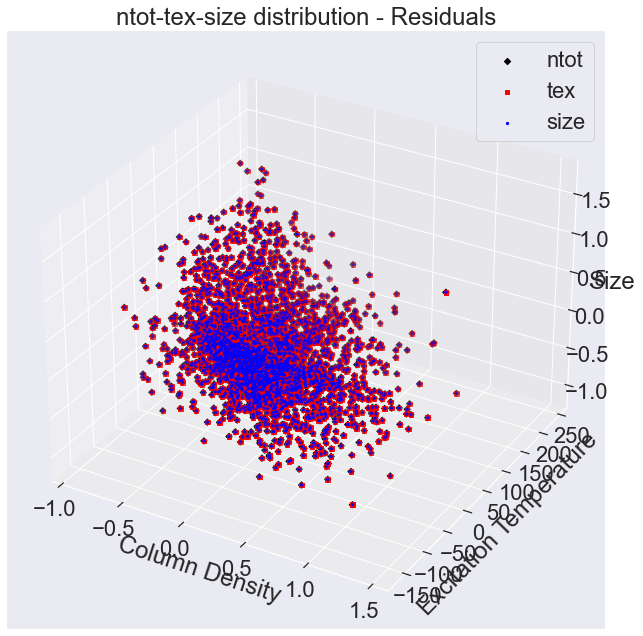

In [56]:
fig = plt.figure(figsize=(26, 11))
plt.setp(ax.get_xticklabels(), fontsize=12)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_rf = (y_test - y_multirf_pred)
# residuals
x1 = residuals_rf['ntot']
y1 = residuals_rf['tex']
z1 = residuals_rf['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

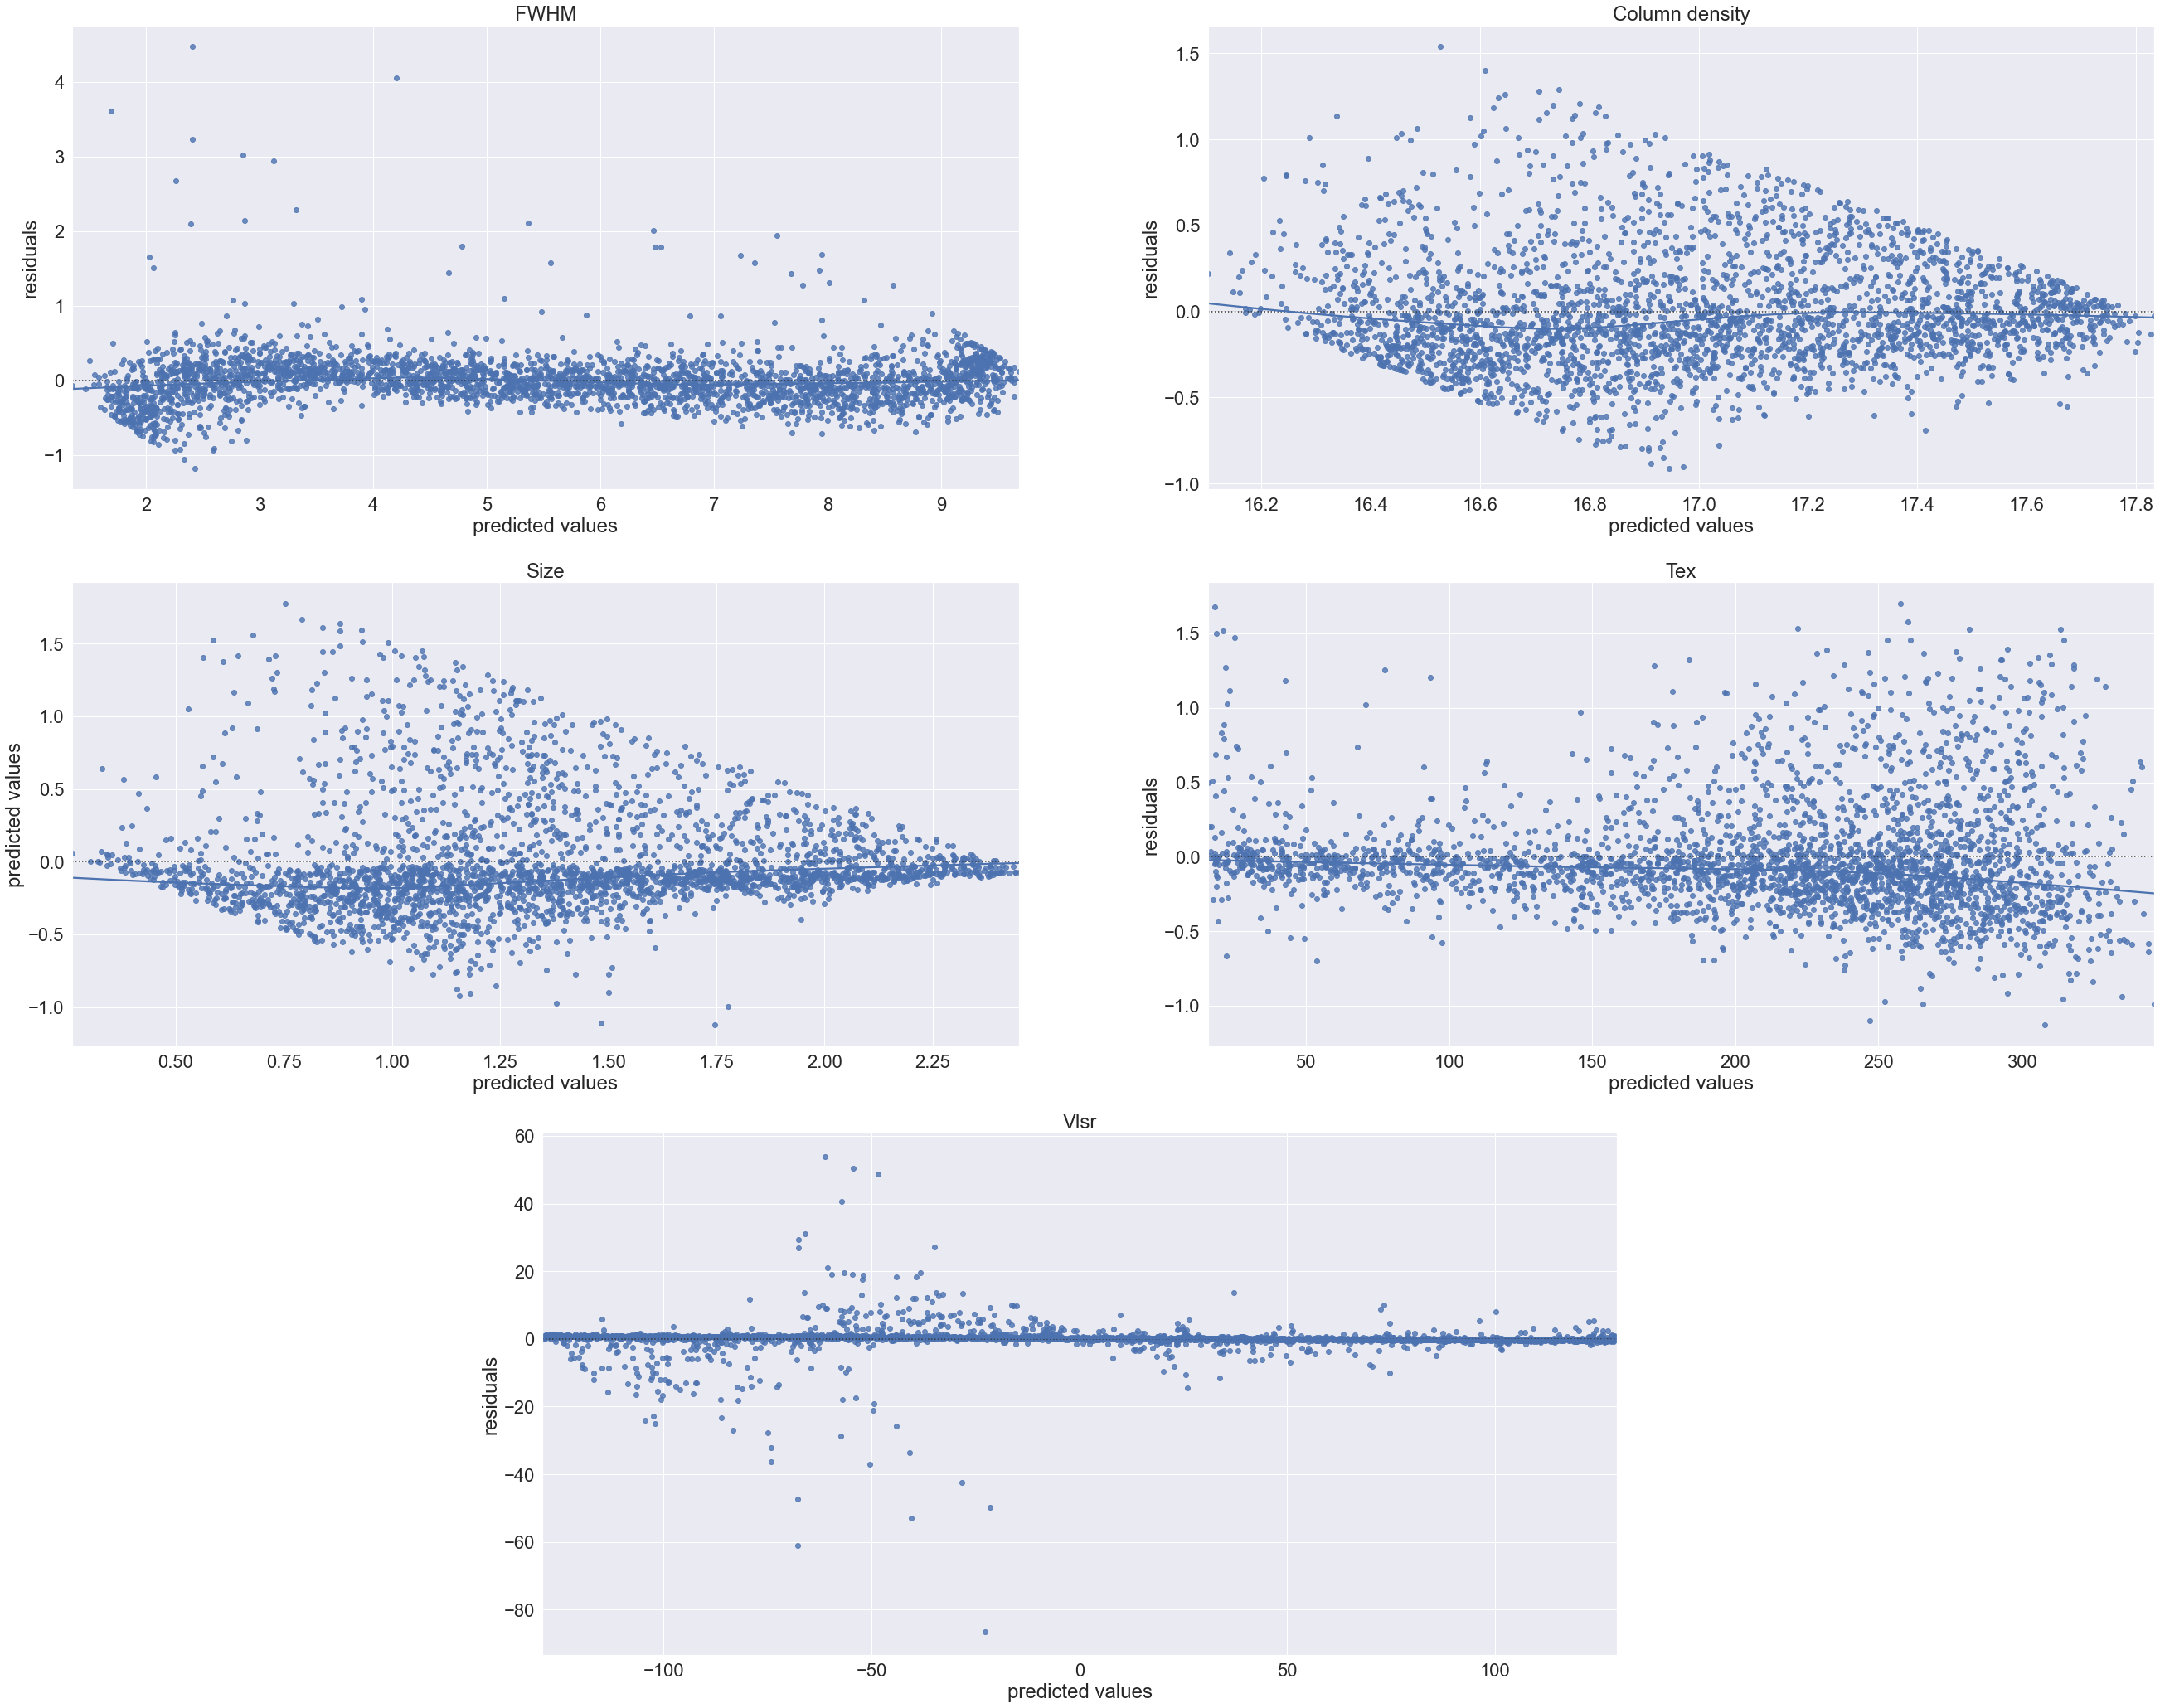

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_pred[:,0], y=residuals_rf['fwhm'], lowess=True, ax=axes[0,0]) # fwhm
g2 = sns.residplot(x=y_multirf_pred[:,1], y=residuals_rf['ntot'], lowess=True, ax=axes[0,1]) # column density
g3 = sns.residplot(x=y_multirf_pred[:,2], y=residuals_rf['size'], lowess=True, ax=axes[1,0]) # size
g4 = sns.residplot(x=y_multirf_pred[:,3], y=residuals_rf['size'], lowess=True, ax=axes[1,1]) # tex
g5 = sns.residplot(x=y_multirf_pred[:,4], y=residuals_rf['vlsr'], lowess=True, ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/10K_gen_files/residuals_RF_10K.png")
plt.show()

In [58]:
param_df_rf

fwhm_rf_pred  ntot_rf_pred  size_rf_pred  tex_rf_pred  vlsr_rf_pred
6252      5.803068  2.849342e+16      0.979896   198.686929    -65.799794
4684      2.738055  2.342626e+17      1.757514   187.077338   -122.814219
1731      4.284896  4.381946e+16      1.974926    59.991608    -44.419422
4742      3.081001  1.469288e+17      1.494495   237.017818    -79.014063
4521      2.717093  2.543642e+17      1.945188   258.876483    -79.914817
...            ...           ...           ...          ...           ...
8014      7.962005  4.474911e+17      2.312484   248.886310    120.633310
1074      4.971298  4.121448e+16      0.643924   292.649078     18.496190
3063      3.992042  1.027004e+17      0.849215   286.090361     58.154923
6487      4.879634  1.242030e+17      2.106247   213.395966    106.607253
4705      8.206207  6.321020e+16      1.190111   295.722528     32.014025

[3000 rows x 5 columns]

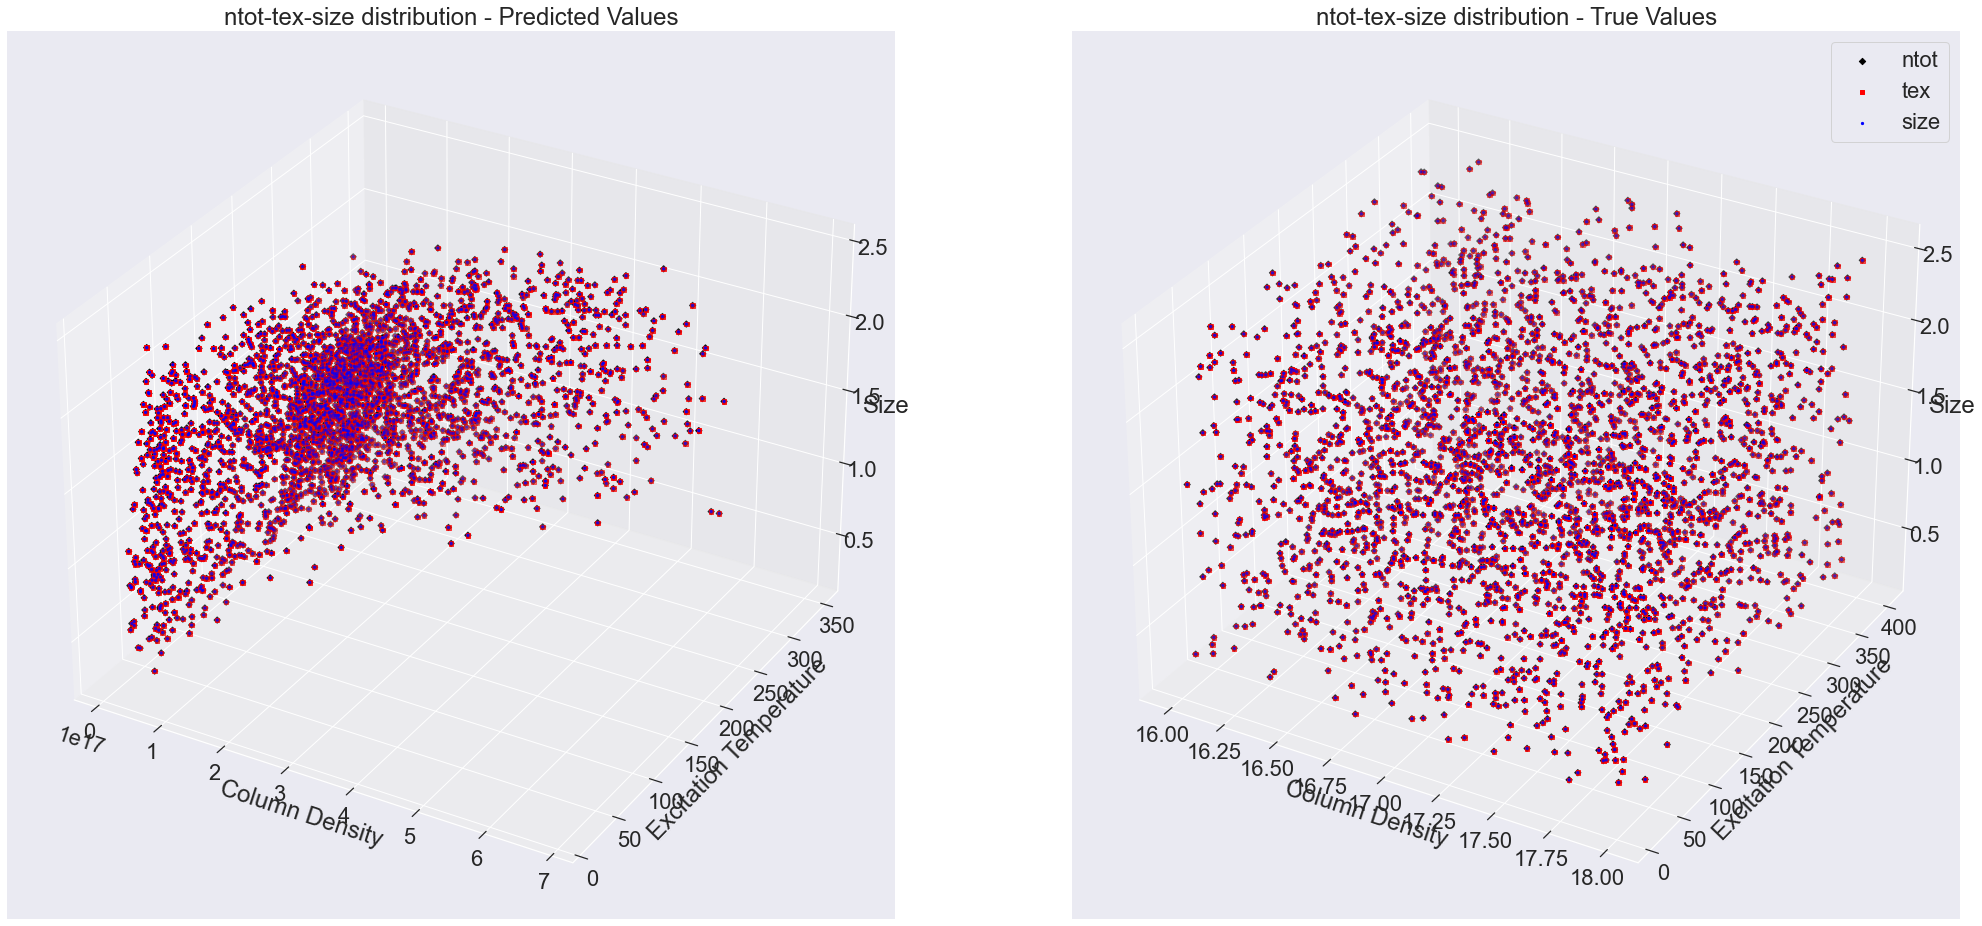

In [59]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    x1 = param_df_rf['ntot_rf_pred']
    y1 = param_df_rf['tex_rf_pred']
    z1 = param_df_rf['size_rf_pred']
    
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density')
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/10K_gen_files/scatter3D_pred_true_10K_RF.png")
plt.show()

## Hyperparameter Tuning for Random Forest

In [ ]:
multirf_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        criterion="squared_error",
        bootstrap=True,
        max_samples=None,
))

multrf_hyperparameters = dict(
    estimator__n_estimators=np.arange(100, 1000, 100),
    estimator__max_depth=np.arange(10, 150, 10)
)


In [ ]:
random_search = RandomizedSearchCV(
    estimator=multirf_model,
    param_distributions=multrf_hyperparameters,
    n_iter=30,
    cv=5,
    verbose=5,
    pre_dispatch="2*n_jobs",
    n_jobs=-1,
    error_score="raise",
    random_state=42,
    return_train_score=True
)

In [ ]:
hyper_rf_tuned_model = random_search.fit(X_train, y_train)

In [ ]:
print("Best hyperparameters: ", hyper_rf_tuned_model.best_params_)
print("Best score: ", hyper_rf_tuned_model.best_score_)

In [ ]:
tuned_model = hyper_rf_tuned_model.best_estimator_
tuned_model.predict(X_test)

In [ ]:
# print(tuned_model)

In [ ]:
# TODO: interpret the model evaluation metrics
# eval = RegressionMetrics()
# for metric in _metrics:
#     print(metric, ":", eval.get_metric(metric, y_test, tuned_model.predict(X_test)))

In [ ]:
# print(y_test.iloc[:,0], y_tuned_pred[:,0])

## 2. XGBoost Regressor

In [60]:
multixgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        max_leaves=10,
        max_bin=10,
        learning_rate=0.1,
        n_jobs=-1,
        gamma=0,
        min_child_weight=1.0,
        max_delta_step=0,
        importance_type="gain",
        eval_metric=metrics.mean_squared_error
))



# xgb_hyperparameters = dict(
#     estimator__n_estimators=np.arange(100, 1000, 100),
#     estimator__max_depth=np.arange(10, 150, 10),
#     estimator__max_leaves=np.arange(10, 150, 10),
#     estimator__max_bin=np.arange(10, 150, 10),
#     # estimator_growth_policy=0,
#     estimator__learning_rate=np.arange(0.1, 1, 0.1),
#     estimator__min_child_weight=np.arange(1.0, 5.0, 0.5),
#     estimator__max_delta_step=np.arange(0, 10, 1),
#     estimator__importance_type=["gain", "weight", "cover", "total_gain", "total_cover"],
#     estimator__eval_metric=[metrics.mean_absolute_error, metrics.mean_squared_error]
# )

# xgbr_rand_search = RandomizedSearchCV(
#     estimator=multixgb_model,
#     param_distributions=xgb_hyperparameters,
#     n_iter=100,
#     cv=3
# )

# xgb_hyperparameters_tuning = xgbr_rand_search.fit(X_train, y_train)
# print('Best Parameters = {}'.format(xgb_hyperparameters_tuning.best_params_))

# xgb_tuned_model = xgb_hyperparameters_tuning.best_estimator_
multixgb_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric=<function mean_squared_error at 0x7fe31a486e50>,
                                            gamma=0, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=10,
                                            max_delta_step=0, max_depth=10,
                                            max_leaves=10, min_child_weight=1.0,
                                            missing=nan,
                                            monoton

In [61]:
# predict on the neew test et
y_multixgb_pred = multixgb_model.predict(X_test)

In [62]:
for metric in _metrics:
    print("Multirf  {}: ".format(metric), metrics_multirf.get_metric(metric, y_test, y_multixgb_pred))

Multirf  mae:  9.56632122678415
Multirf  mse:  727.0246348063379
Multirf  rmse:  26.963394348752495
Multirf  mape:  fwhm     5.153488
ntot     1.639627
size    36.438155
tex     32.374928
vlsr    22.125071
dtype: float64
Multirf  r2:  0.7762128242378369
Multirf  msle:  26.963394348752495


### Predicted vs True values Plots - XGB Regressor

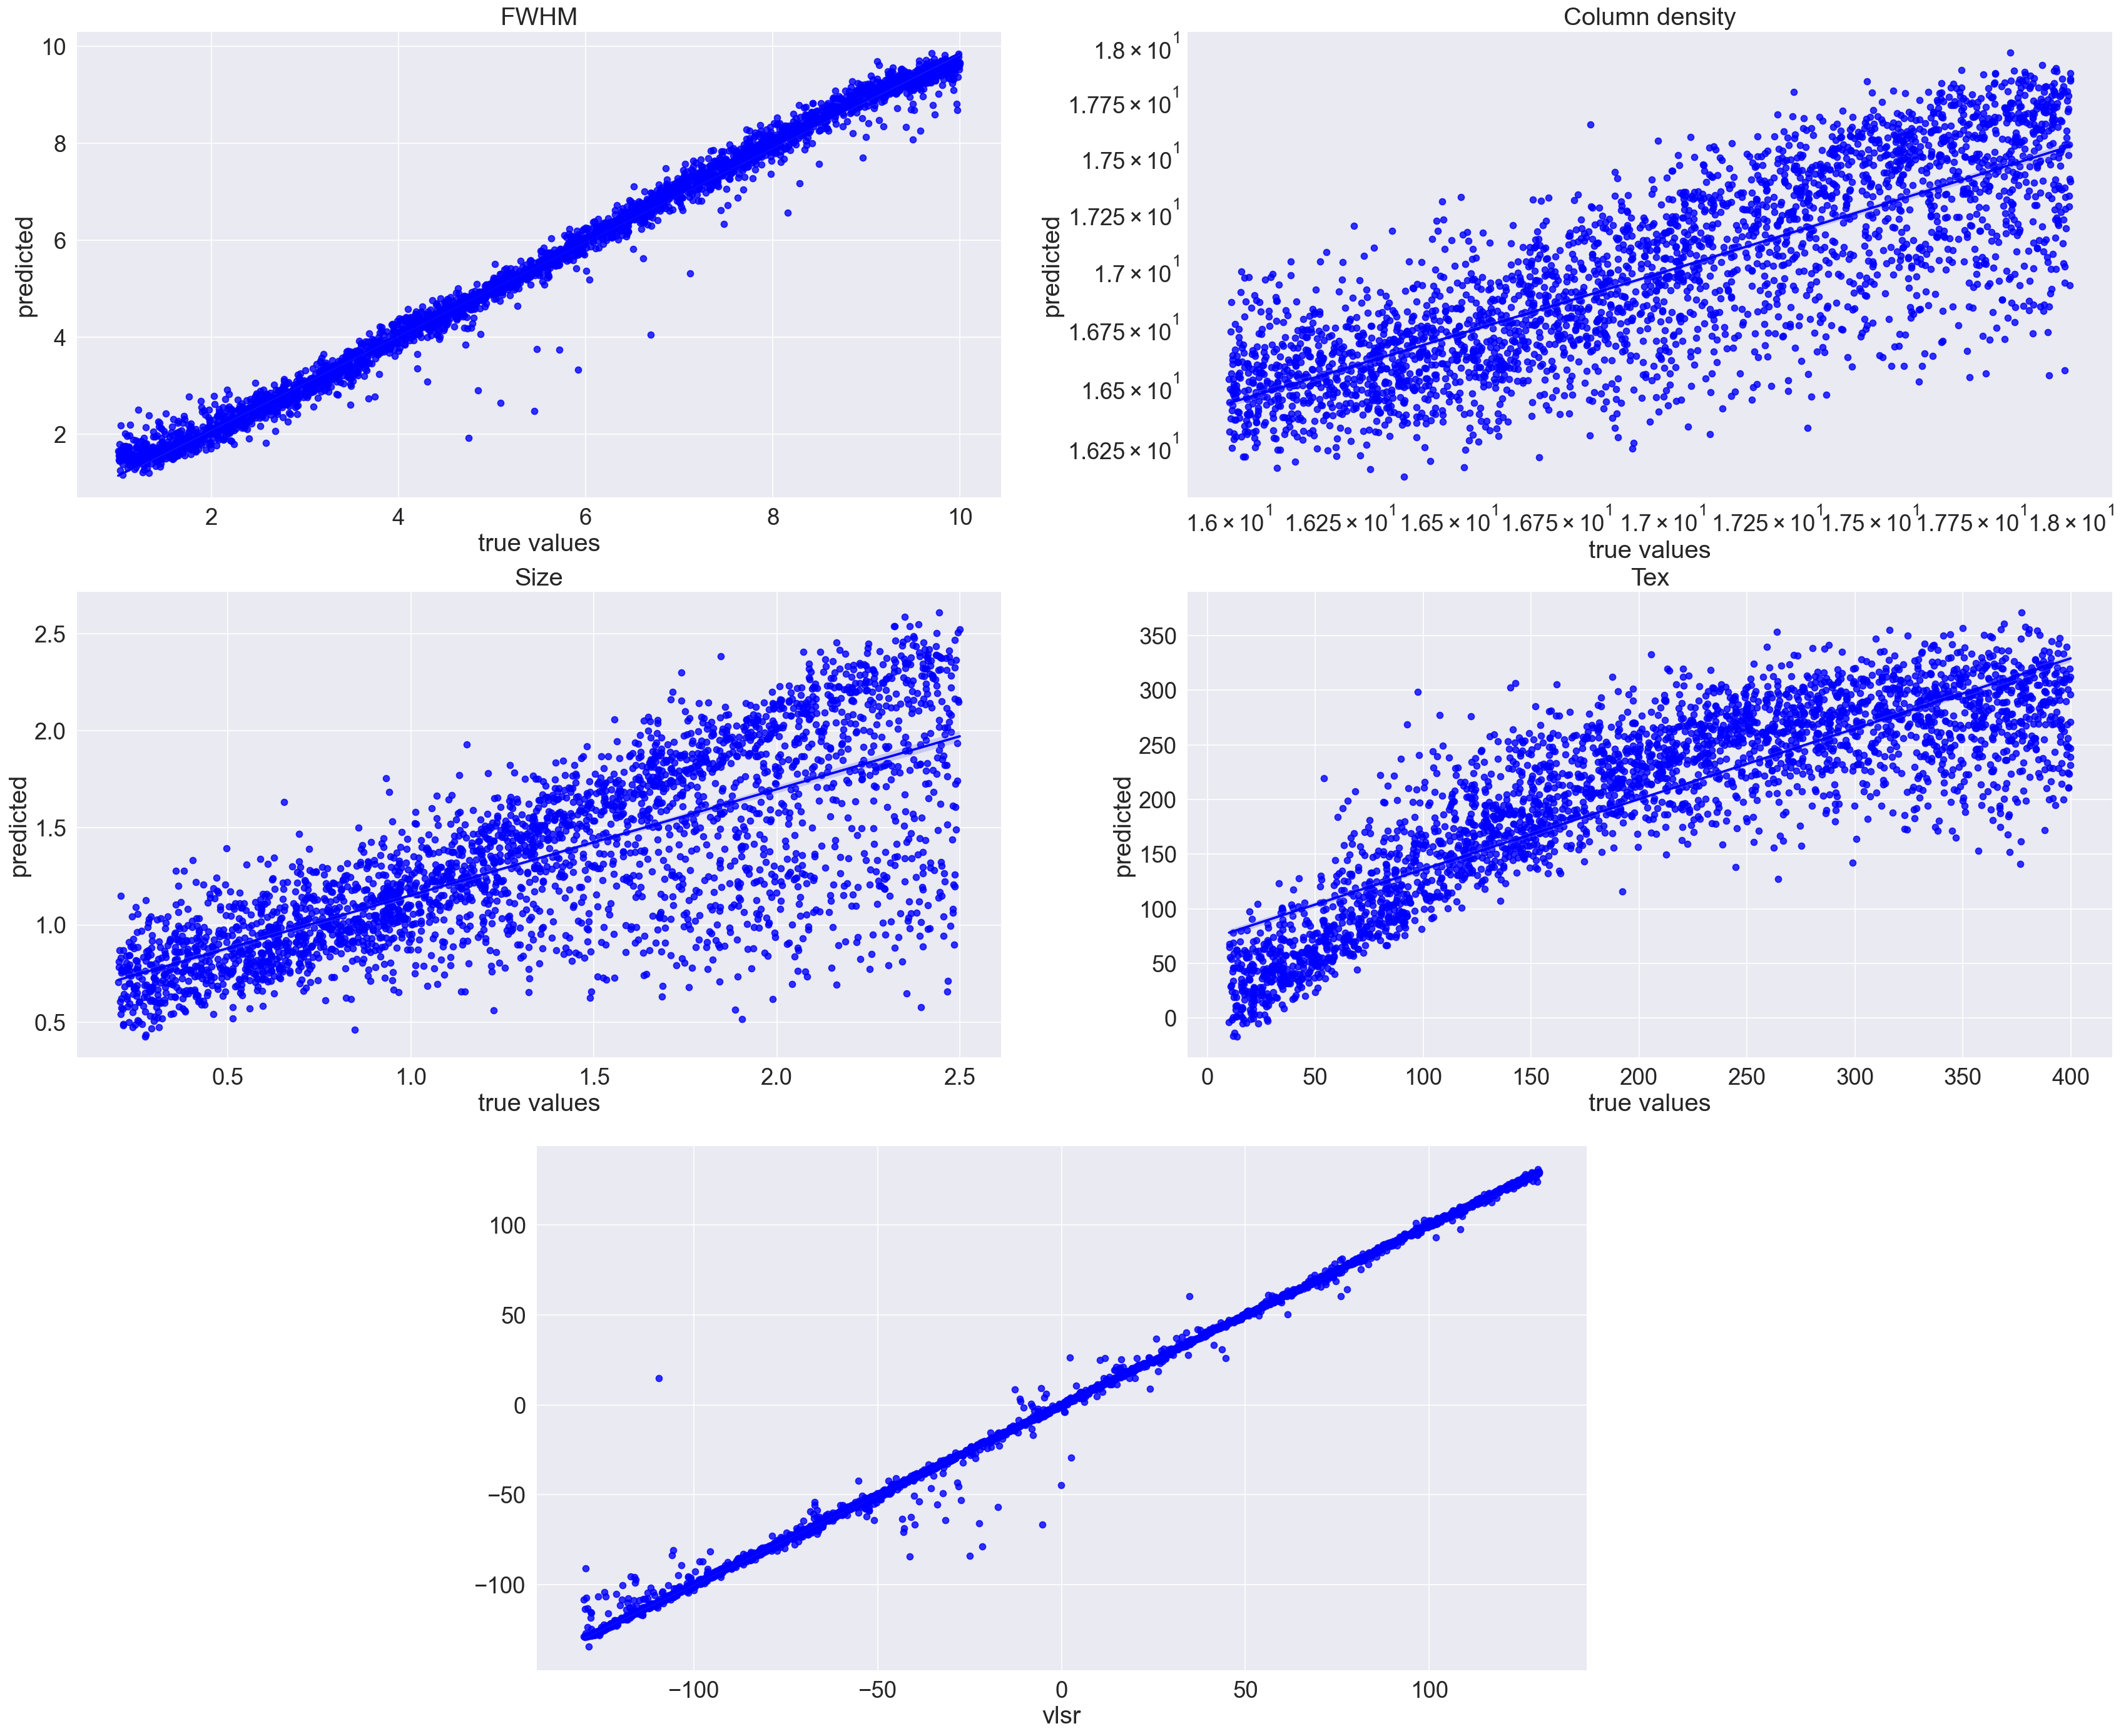

In [63]:
fig, axes = plt.subplots(3, 2, figsize=(35,28), dpi=120)
sns.set_theme(style='whitegrid', font_scale=2)
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])


g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multixgb_pred[:,0], color='blue', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multixgb_pred[:,1], color='blue', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multixgb_pred[:,2], color='blue', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multixgb_pred[:,3], color='blue', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multixgb_pred[:,4], color='blue', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted", xlabel="true values")
g2.set(title='Column density', ylabel="predicted", xlabel="true values", yscale="log", xscale="log")
g3.set(title='Size', ylabel="predicted", xlabel="true values")
g4.set(title='Tex', ylabel="predicted", xlabel="true values")
# g5.set(title='Vlsr', ylabel="predicted", xlabel="true values")

plt.show()

### 3D scatter splots -  Columnn density, Excitation temperature and Size (XGB Regresoor)

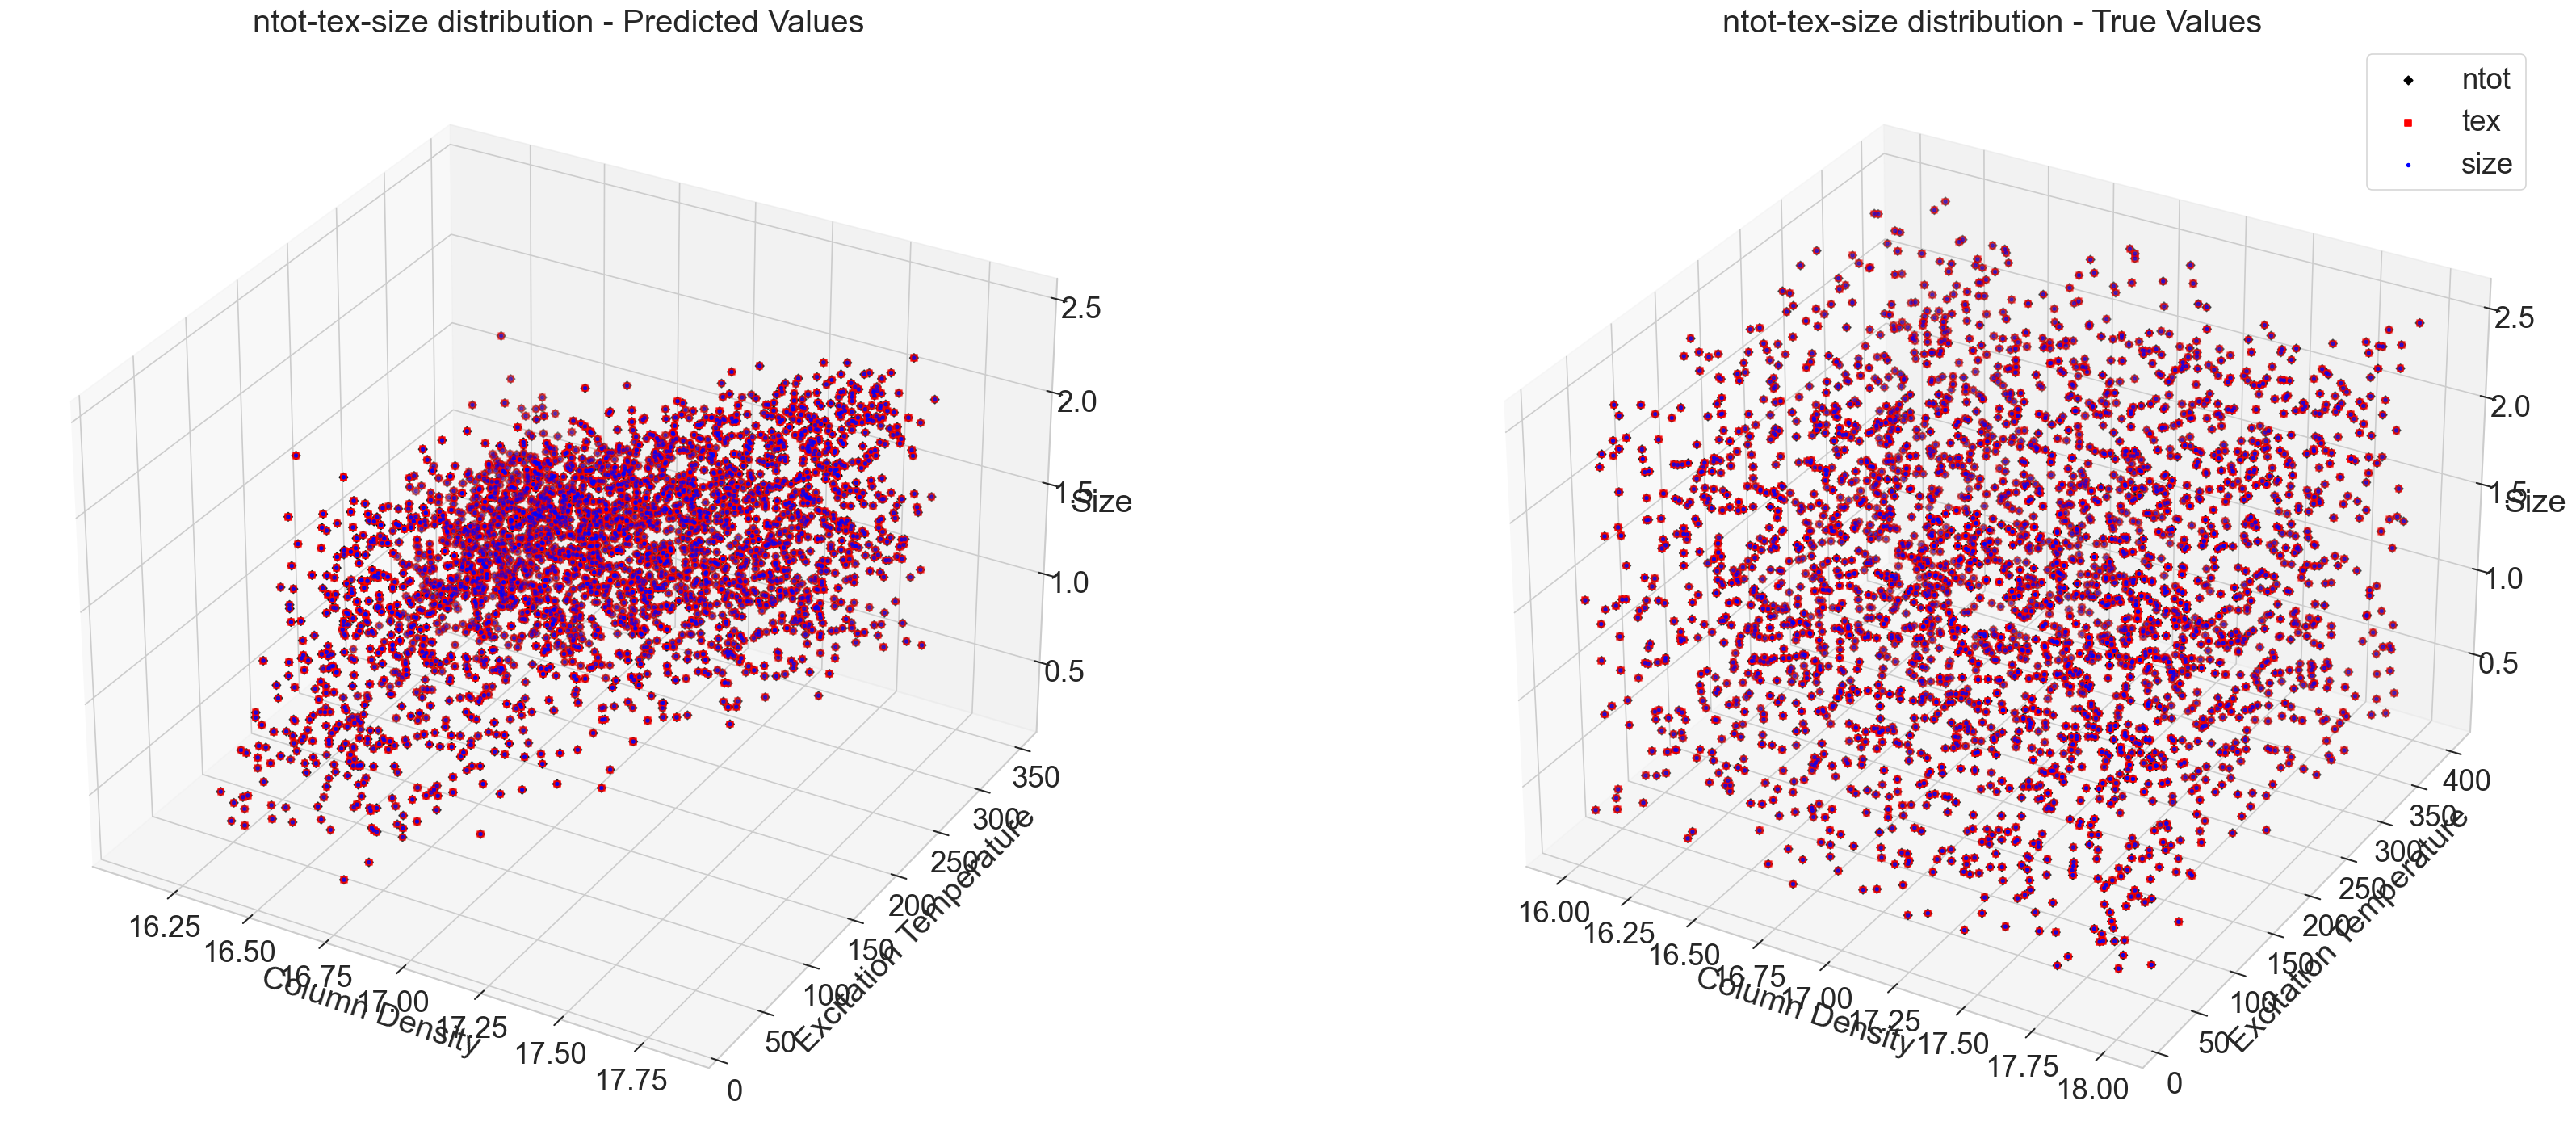

In [64]:
fig = plt.figure(figsize=(35, 15), dpi=120)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']


x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    x1 = pred_param['ntot']
    y1 = pred_param['tex']
    z1 = pred_param['size']
    
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density')
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")
plt.show()